# Environment

In [ ]:
!pip install pydub noisereduce tensorflow

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.1 MB/s eta 0:00:00


In [ ]:
!pip install editdistance

# Libraries

In [ ]:
import os
import re, json, pickle, warnings
import string
import random
import unicodedata
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from pydub import AudioSegment
import noisereduce as nr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint

from sklearn.model_selection import train_test_split
from jiwer import wer, cer
from transformers import AutoTokenizer
from keras.models import load_model
from jiwer import wer, cer
import editdistance

warnings.filterwarnings("ignore")


# Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content

/content


## unrar dataset

In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!unrar x "/content/drive/MyDrive/common_voices_wav_denoised.rar" "/content"

Streaming output truncated to the last 5000 lines.
Extracting  /content/common_voices_wav_denoised/common_voice_en_28382214.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28382875.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28382879.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28382892.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28382914.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28387939.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28387976.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28391007.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/common_voice_en_28391018.wav      90%  OK 
Extracting  /content/common_voices_wav_denoised/c

# Load dataset

In [ ]:
%cd /content

/content


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CV_cleaned.csv")

In [ ]:
df.head()

,audio,sentence,mfcc_path,spectrogram_path
0,./common_voices_wav_denoised/common_voice_en_2...,it consists of a small valley which is drained...,./features/mfcc/common_voice_en_21876051.npy,./features/spectrogram/common_voice_en_2187605...
1,./common_voices_wav_denoised/common_voice_en_2...,he alternated shows with alfred molina who por...,./features/mfcc/common_voice_en_23404685.npy,./features/spectrogram/common_voice_en_2340468...
2,./common_voices_wav_denoised/common_voice_en_2...,little havana is the best known neighborhood f...,./features/mfcc/common_voice_en_20584803.npy,./features/spectrogram/common_voice_en_2058480...
3,./common_voices_wav_denoised/common_voice_en_1...,matsakis will be accused of smuggling antiquities,./features/mfcc/common_voice_en_19552513.npy,./features/spectrogram/common_voice_en_1955251...
4,./common_voices_wav_denoised/common_voice_en_2...,the team currently plays in league two england...,./features/mfcc/common_voice_en_27932383.npy,./features/spectrogram/common_voice_en_2793238...


In [ ]:
print("Max sentence length:", df['sentence'].str.len().max())

Max sentence length: 156


# Preprocessing

## Text Cleaning

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z ]", "", text)  # remove punctuation
    return re.sub(r"\s+", " ", text).strip()

In [ ]:
df['sentence'] = df['sentence'].apply(clean_text)

In [ ]:
df.head()

,audio,sentence,mfcc_path,spectrogram_path
0,./common_voices_wav_denoised/common_voice_en_2...,it consists of a small valley which is drained...,./features/mfcc/common_voice_en_21876051.npy,./features/spectrogram/common_voice_en_2187605...
1,./common_voices_wav_denoised/common_voice_en_2...,he alternated shows with alfred molina who por...,./features/mfcc/common_voice_en_23404685.npy,./features/spectrogram/common_voice_en_2340468...
2,./common_voices_wav_denoised/common_voice_en_2...,little havana is the best known neighborhood f...,./features/mfcc/common_voice_en_20584803.npy,./features/spectrogram/common_voice_en_2058480...
3,./common_voices_wav_denoised/common_voice_en_1...,matsakis will be accused of smuggling antiquities,./features/mfcc/common_voice_en_19552513.npy,./features/spectrogram/common_voice_en_1955251...
4,./common_voices_wav_denoised/common_voice_en_2...,the team currently plays in league two england...,./features/mfcc/common_voice_en_27932383.npy,./features/spectrogram/common_voice_en_2793238...


In [ ]:
df.drop(['mfcc_path', 'spectrogram_path'], axis=1, inplace=True)

In [ ]:
df.head()

,audio,sentence
0,./common_voices_wav_denoised/common_voice_en_2...,it consists of a small valley which is drained...
1,./common_voices_wav_denoised/common_voice_en_2...,he alternated shows with alfred molina who por...
2,./common_voices_wav_denoised/common_voice_en_2...,little havana is the best known neighborhood f...
3,./common_voices_wav_denoised/common_voice_en_1...,matsakis will be accused of smuggling antiquities
4,./common_voices_wav_denoised/common_voice_en_2...,the team currently plays in league two england...


## Extract Features

In [ ]:
# create new directories
spectrogram_dir = "/content/features/spectrogram"
os.makedirs(spectrogram_dir, exist_ok=True)

In [ ]:
SAMPLE_RATE = 16000
N_MELS = 128
WIN_LENGTH = int(0.025 * SAMPLE_RATE)  # 25ms
HOP_LENGTH = int(0.010 * SAMPLE_RATE)  # 10ms
def extract_features(audio_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(audio_path, sr=sr)
    y, _ = librosa.effects.trim(y)

    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=1024, n_mels=N_MELS,
        hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
        window="hann", power=2.0
    )
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize
    log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-9)
    return log_mel.T.astype(np.float32)  # (Time, Mel)

In [ ]:
# Extract + Save Features
spectrogram_paths = []

for i, audio_path in enumerate(df['audio'], start=1):
    try:
        filename = os.path.basename(audio_path).replace(".wav", ".npy")
        spec = extract_features(audio_path)
        path = os.path.join(spectrogram_dir, filename)
        np.save(path, spec)
        spectrogram_paths.append(path)
    except Exception as e:
        print(f"Error with {audio_path}: {e}")
        spectrogram_paths.append(None)
    if i % 2000 == 0:
        print(f"{i}/{len(df)} processed")

df['spectrogram_path'] = spectrogram_paths

2000/50000 processed
4000/50000 processed
6000/50000 processed
8000/50000 processed
10000/50000 processed
12000/50000 processed
14000/50000 processed
16000/50000 processed
18000/50000 processed
20000/50000 processed
22000/50000 processed
24000/50000 processed
26000/50000 processed
28000/50000 processed
30000/50000 processed
32000/50000 processed
34000/50000 processed
36000/50000 processed
38000/50000 processed
40000/50000 processed
42000/50000 processed
44000/50000 processed
46000/50000 processed
48000/50000 processed
50000/50000 processed


In [ ]:
df.head()

,audio,sentence,spectrogram_path
0,./common_voices_wav_denoised/common_voice_en_2...,it consists of a small valley which is drained...,/content/features/spectrogram/common_voice_en_...
1,./common_voices_wav_denoised/common_voice_en_2...,he alternated shows with alfred molina who por...,/content/features/spectrogram/common_voice_en_...
2,./common_voices_wav_denoised/common_voice_en_2...,little havana is the best known neighborhood f...,/content/features/spectrogram/common_voice_en_...
3,./common_voices_wav_denoised/common_voice_en_1...,matsakis will be accused of smuggling antiquities,/content/features/spectrogram/common_voice_en_...
4,./common_voices_wav_denoised/common_voice_en_2...,the team currently plays in league two england...,/content/features/spectrogram/common_voice_en_...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   audio             50000 non-null  object
 1   sentence          50000 non-null  object
 2   spectrogram_path  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


# Visualize MFCC & Spectrogram

In [ ]:
def plot_features(spectrogram_path, sentence):
    # Load features
    spectrogram = np.load(spectrogram_path)

    #create plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Spectrogram
    axes[0].imshow(spectrogram.T, aspect='auto', origin='lower', cmap='magma')
    axes[0].set_title("Spectrogram")
    axes[0].set_xlabel("Time Frames")
    axes[0].set_ylabel("Mel Frequency Bands")

    # Add title with sentence
    fig.suptitle(f"Sentence: {sentence}", fontsize=10)
    plt.tight_layout()
    plt.show()

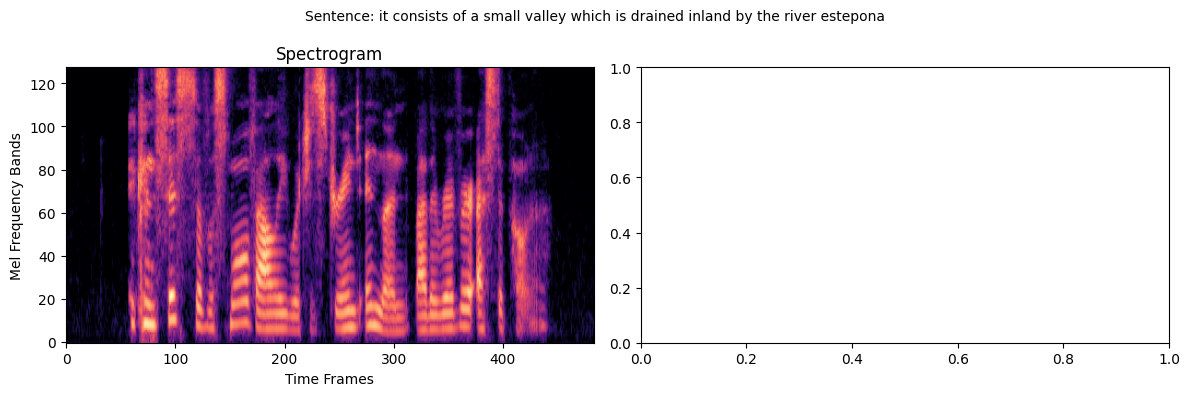

In [ ]:
# select sample index
sample_idx = 0
sample = df.iloc[sample_idx]

# Plot the features
plot_features(sample["spectrogram_path"], sample["sentence"])

# Train/Validation/Test Split

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Train:", len(train_df), "-- Val:", len(val_df), " -- Test:", len(test_df))

Train: 40000 -- Val: 5000  -- Test: 5000


# Tokenizer

In [ ]:
VOCAB = ["'", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n",
         "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", " "]

# Char to index 
CHAR2IDX = {c: i for i, c in enumerate(VOCAB)}  # 0 to 27
IDX2CHAR = {i: c for c, i in CHAR2IDX.items()}

# TensorFlow CTC expects num_classes = vocab_size + 1 (for blank)
vocab_size = len(VOCAB) + 1  # 28 + 1 = 29

In [ ]:
def encode_text(text):
    return [CHAR2IDX[c] for c in text if c in CHAR2IDX]

def decode_sequence(seq):
    return ''.join([IDX2CHAR.get(i, '') for i in seq])

In [ ]:
# Max lengths
max_input_len = max(np.load(p).shape[0] for p in train_df['spectrogram_path'])
max_label_len = max(len(encode_text(s)) for s in train_df['sentence'])

In [ ]:
print(max_input_len)
print(max_label_len)

4370
156


#  TF Dataset Generator

In [ ]:
def parse_example(spectrogram_path, sentence):
    try:
        spec = np.load(spectrogram_path.decode())
        label = encode_text(sentence.decode())
        return spec, np.array(label, dtype=np.int32)
    except Exception as e:
        print(f"Error in parse_example: {e}")
        return np.zeros((1, 128), dtype=np.float32), np.array([0], dtype=np.int32)

def tf_parse(spectrogram_path, sentence):
    spec, label = tf.numpy_function(parse_example, [spectrogram_path, sentence], [tf.float32, tf.int32])
    spec.set_shape([None, 128])
    label.set_shape([None])
    return spec, label

def make_dataset(df, batch_size=32):
    def _prepare(spec, label):
        spec = tf.pad(spec, [[0, max_input_len - tf.shape(spec)[0]], [0, 0]], constant_values=-1.0)
        label = tf.pad(label, [[0, max_label_len - tf.shape(label)[0]]], constant_values=0)
        return spec, label

    ds = tf.data.Dataset.from_tensor_slices((df['spectrogram_path'].values, df['sentence'].values))
    ds = ds.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(_prepare, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
batch_size = 32
train_ds = make_dataset(train_df, batch_size)
val_ds = make_dataset(val_df, batch_size)
test_ds = make_dataset(test_df, batch_size)

In [ ]:
for spec, label in train_ds.take(5):
    print("Spec shape:", spec.shape)
    print("Label shape:", label.shape)


Spec shape: (64, 4370, 128)
Label shape: (64, 156)
Spec shape: (64, 4370, 128)
Label shape: (64, 156)
Spec shape: (64, 4370, 128)
Label shape: (64, 156)
Spec shape: (64, 4370, 128)
Label shape: (64, 156)
Spec shape: (64, 4370, 128)
Label shape: (64, 156)


# Data Statistics

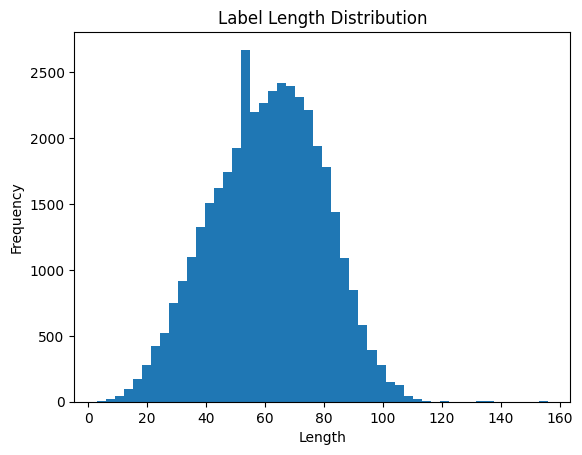

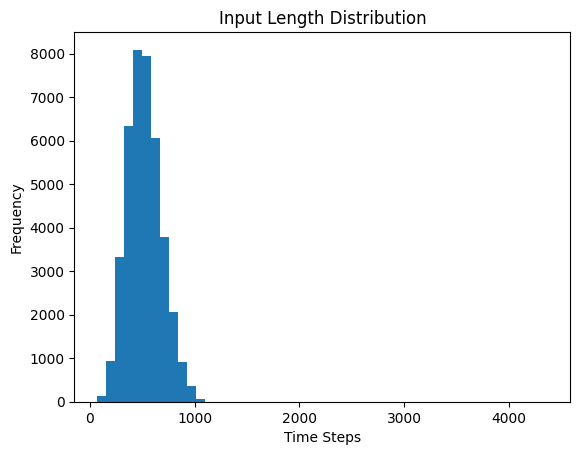

In [ ]:
def plot_histogram_lengths(df):
    lengths = df['sentence'].apply(lambda x: len(encode_text(x)))
    plt.hist(lengths, bins=50)
    plt.title("Label Length Distribution")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

    input_lens = []
    for path in df['spectrogram_path']:
        spec = np.load(path)
        input_lens.append(spec.shape[0])
    plt.hist(input_lens, bins=50)
    plt.title("Input Length Distribution")
    plt.xlabel("Time Steps")
    plt.ylabel("Frequency")
    plt.show()

plot_histogram_lengths(train_df)

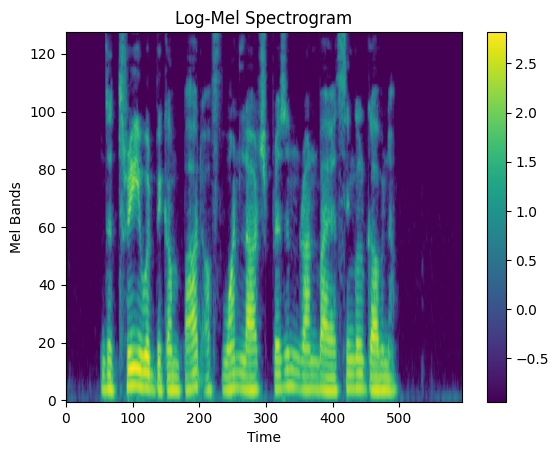

In [ ]:
# Visualize Spectrogram Example
def visualize_spectrogram(path):
    spec = np.load(path)
    plt.imshow(spec.T, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title('Log-Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Bands')
    plt.show()

visualize_spectrogram(train_df['spectrogram_path'].iloc[0])

# build model

In [ ]:
def build_model(input_dim, vocab_size):
    input_spectrogram = layers.Input(shape=(None, input_dim), name="input")  # (B, T, 128)

    # Feature extractor
    x = layers.Masking(mask_value=0.0)(input_spectrogram)
    x = layers.Conv1D(256, kernel_size=11, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(256, kernel_size=11, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # RNN layers
    for _ in range(3):
        x = layers.Bidirectional(layers.LSTM(
            512, return_sequences=True, dropout=0.3,
            activation='tanh', recurrent_activation='sigmoid',
            implementation=1
        ))(x)

    outputs = layers.Dense(vocab_size, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_spectrogram, outputs=outputs, name="Speech_Recognition")
    return model

## CTC Loss

In [ ]:
#tf.config.optimizer.set_jit(False)

In [ ]:
class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, inputs, training=False):
        return self.base_model(inputs, training=training)

   # @tf.function(jit_compile=False)  
    def train_step(self, data):
        x, y_true = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)

            input_len = tf.fill([tf.shape(x)[0], 1], tf.shape(y_pred)[1])
            label_len = tf.expand_dims(tf.reduce_sum(tf.cast(tf.math.not_equal(y_true, 0), tf.int32), axis=1), axis=-1)

            loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": tf.reduce_mean(loss)}


In [ ]:
BLANK_INDEX = vocab_size - 1  # 28, the implicit blank token index used by CTC

def greedy_decode(logits):
    pred = tf.argmax(logits, axis=-1).numpy()
    results = []
    for seq in pred:
        decoded = []
        previous = BLANK_INDEX
        for idx in seq:
            if idx != previous and idx != BLANK_INDEX:
                decoded.append(IDX2CHAR.get(idx, ''))  # Safe lookup
            previous = idx
        results.append("".join(decoded))
    return results


In [ ]:
def compute_wer_cer(pred_texts, true_texts):
    wer_value = wer(true_texts, pred_texts)
    cer_value = np.mean([editdistance.eval(p, t) / max(1, len(t)) for p, t in zip(pred_texts, true_texts)])
    return wer_value, cer_value

In [ ]:
def train_model(model, base_model, train_ds, val_ds, epochs=30, patience=5, lr_scheduler=True):
    best_wer = float("inf")
    epochs_since_improvement = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.fit(train_ds, epochs=1, verbose=1)

        all_preds, all_trues = [], []
        for x_batch, y_batch in val_ds:
            logits = base_model(x_batch, training=False)
            pred_texts = greedy_decode(logits)
            true_texts = ["".join(IDX2CHAR[i] for i in label if i != 0) for label in y_batch.numpy()]
            all_preds.extend(pred_texts)
            all_trues.extend(true_texts)

        wer_val, cer_val = compute_wer_cer(all_preds, all_trues)
        print(f"Validation WER: {wer_val:.3f} | CER: {cer_val:.3f}")

        # Early stopping check
        if wer_val < best_wer:
            best_wer = wer_val
            epochs_since_improvement = 0
            # Save best model
            base_model.save("/content/drive/MyDrive/best_speech_model.keras")
            print("✅ Best model saved.")
        else:
            epochs_since_improvement += 1
            print(f"No improvement. Patience counter: {epochs_since_improvement}/{patience}")

        # Learning rate scheduler
        if lr_scheduler and epochs_since_improvement > 0 and epochs_since_improvement % 2 == 0:
            old_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
            new_lr = old_lr * 0.5
            tf.keras.backend.set_value(model.optimizer.lr, new_lr)
            print(f"🔁 Reducing learning rate: {old_lr:.1e} → {new_lr:.1e}")

        # Stop if no improvement for `patience` epochs
        if epochs_since_improvement >= patience:
            print("⛔ Early stopping triggered.")
            break


In [ ]:
# Build and compile the model
base_model = build_model(input_dim=128, vocab_size=vocab_size)
model = CTCLossModel(base_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), jit_compile=False)

train_model(model, base_model, train_ds, val_ds, epochs=30, patience=6)




Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 692s 548ms/step - loss: 160.9130
Validation WER: 0.986 | CER: 0.566
✅ Best model saved.

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 685s 548ms/step - loss: 105.8143
Validation WER: 0.932 | CER: 0.532
✅ Best model saved.

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 685s 548ms/step - loss: 90.3867
Validation WER: 0.874 | CER: 0.402
✅ Best model saved.

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 684s 547ms/step - loss: 81.0918
Validation WER: 0.838 | CER: 0.379
✅ Best model saved.

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 683s 547ms/step - loss: 74.1830
Validation WER: 0.802 | CER: 0.353
✅ Best model saved.

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 683s 546ms/step - loss: 68.6071
Validation WER: 0.789 | CER: 0.336
✅ Best model saved.

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 683s 546ms/step - loss: 64.0948
Validation WER: 0.775 | CER: 0.341
✅ Best model saved.

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 684s 548ms/step - loss: 75.1083
Validation WE

In [ ]:
base_model.save("speech_recognition_model.keras")

# Load model

In [ ]:
base_model = load_model("/content/drive/MyDrive/best_speech_model.keras")

In [ ]:
model = CTCLossModel(base_model)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), jit_compile=False)

# Now continue training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), jit_compile=False)

train_model(model, base_model, train_ds, val_ds, epochs=30, patience=6)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 688s 544ms/step - loss: 28.6732
Validation WER: 0.663 | CER: 0.269
✅ Best model saved.

Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 681s 545ms/step - loss: 27.8269
Validation WER: 0.660 | CER: 0.269
✅ Best model saved.

Epoch 3/10
 280/1250 ━━━━━━━━━━━━━━━━━━━━ 8:47 544ms/step - loss: 27.0200

KeyboardInterrupt: 